##### Copyright 2019 The TensorFlow Hub Authors.
Licensed under the Apache License, Version 2.0 (the "License");

Created by @[Adrish Dey](https://github.com/captain-pool) for [Google Summer of Code](https://summerofcode.withgoogle.com/) 2019

In [ ]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, 
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Image Super Resolution using ESRGAN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/image_enhancing"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/image_enhancing.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/image_enhancing.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/image_enhancing.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/captain-pool/esrgan-tf2/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This colab demonstrates use of TensorFlow Hub Module for Enhanced Super Resolution Generative Adversarial Network (*by Xintao Wang et.al.*) [[Paper](https://arxiv.org/pdf/1809.00219.pdf)] [[Code](https://github.com/captain-pool/GSOC/)]

for image enhancing. *(Preferrably bicubically downsampled images).*

Model trained on DIV2K Dataset (on bicubically downsampled images) on image patches of size 128 x 128.

**Preparing Environment**

In [ ]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [ ]:
!wget "https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png" -O original.png

--2022-07-08 10:51:48--  https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34146 (33K) [image/png]
Saving to: ‘original.png’

original.png        100%[===================>]  33.35K  --.-KB/s    in 0.002s  

2022-07-08 10:51:48 (14.0 MB/s) - ‘original.png’ saved [34146/34146]



In [ ]:
# Declaring Constants
IMAGE_PATH = "original.png"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

**Defining Helper Functions**

In [ ]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  #hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = cv2.resize(np.asarray(hr_image), (256, 256), interpolation = cv2.INTER_AREA)
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [ ]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

#### Performing Super Resolution of images loaded from path

In [ ]:
hr_image = preprocess_image(IMAGE_PATH_HIGH[0])

Saved as Original Image.jpg


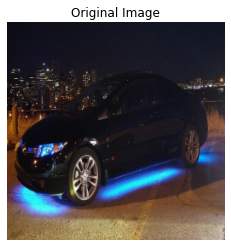

In [ ]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [ ]:
model = hub.load(SAVED_MODEL_PATH)

In [ ]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

In [ ]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

### Evaluating Performance of the Model

In [ ]:
!wget "https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64" -O test.jpg
IMAGE_PATH = "test.jpg"

In [ ]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [ ]:
hr_image = preprocess_image(IMAGE_PATH)

In [ ]:
lr_image = downscale_image(tf.squeeze(hr_image))

In [ ]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [ ]:
model = hub.load(SAVED_MODEL_PATH)

In [ ]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

In [ ]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

**Comparing Outputs size by side.**

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)

In [ ]:
#@title MAIN PROGRAM

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#IMAGE_PATH_NEW = "/content/gdrive/MyDrive/Pre-Train-Model_DPL/DATASET_TEST/Blur/defocused_blurred"
from glob import glob
IMAGE_PATH_NEW = sorted(glob("/content/gdrive/MyDrive/Pre-Train-Model_DPL/DATASET_TEST/Blur/defocused_blurred/*"))
print('Total test images {}'.format(len(IMAGE_PATH_NEW)))

In [ ]:
PSNR_LIST_NEW = []

In [ ]:
#@title Demo mini( Could skip for this step)

In [ ]:
hr_image = preprocess_image(IMAGE_PATH_NEW[0])
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [ ]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

In [ ]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

In [ ]:
#@title End of Demo mini

In [ ]:
#@title Use library to calculate PSNR

In [ ]:
model = hub.load(SAVED_MODEL_PATH)

In [ ]:
import cv2 
dim = (128, 128)


for i_path in IMAGE_PATH_NEW:
  hr_image = preprocess_image(i_path)
  fake_image = model(hr_image)
  fake_image = tf.squeeze(fake_image)
  hr_image = tf.squeeze(hr_image)
  fake_image_resized = cv2.resize(np.asarray(fake_image), dim, interpolation = cv2.INTER_AREA)
  hr_image_resized = cv2.resize(np.asarray(hr_image), dim, interpolation = cv2.INTER_AREA)
  psnr = tf.image.psnr(
        tf.clip_by_value(fake_image_resized, 0, 255),
        tf.clip_by_value(hr_image_resized, 0, 255), max_val=255)
  PSNR_LIST_NEW.append(psnr)
  print("PSNR Achieved: %f" % psnr)
  


In [ ]:
import cv2
 
img = cv2.imread("/content/original.png", cv2.IMREAD_UNCHANGED)
dim = (128, 128)
fake_image_resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
 
print('Original Dimensions : ',img.shape)
print('R_Dimensions : ',fake_image_resized.shape)
print(type(img))

In [ ]:
print(fake_image.shape)
print(hr_image_new.shape)
lr_image = tf.squeeze(hr_image_new)
print(lr_image.shape)
print(type(np.asarray(hr_image)))
print(i_path.shape)

In [ ]:
#@title Build code to calculate PSNR

In [ ]:
from math import log10, sqrt
import cv2
import numpy as np

PSNR_LIST = []
  
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
  
def main_program():
     #original = cv2.imread("original_image.png")
     #compressed = cv2.imread("compressed_image.png", 1)
     for image_path in IMAGE_PATH_NEW:
       #original_image, preprocessed_image = preprocess_image(image_path)
       #output_image = infer_tflite(preprocessed_image)
       hr_image = preprocess_image(i_path)
       hr_image_new = tf.clip_by_value(hr_image, 0, 255)

       fake_image = model(hr_image_new)
       fake_image = tf.squeeze(fake_image)

       im_np_01 = np.asarray(hr_image_new)
       im_np_02 = np.asarray(fake_image)

       original = im_np_01
       compressed = im_np_02

       #original = cv2.imread(original_image)
       #compressed = cv2.imread(output_image)
       value = PSNR(original, compressed)
       PSNR_LIST.append(value)
       print(f"PSNR value is {value} dB")


main_program()

In [ ]:
import cv2
 
# read image
img = cv2.imread(IMAGE_PATH_NEW[5], cv2.IMREAD_UNCHANGED)
 
# get dimensions of image
dimensions = img.shape
 
# height, width, number of channels in image
height = img.shape[0]
width = img.shape[1]
channels = img.shape[2]

print('Image Dimension    : ',dimensions)
print('Image Height       : ',height)
print('Image Width        : ',width)
print('Number of Channels : ',channels)

# MAIN PROGRAM

In [1]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [2]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  #hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = cv2.resize(np.asarray(hr_image), (256, 256), interpolation = cv2.INTER_AREA)
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [3]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [4]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [ ]:
#@title Set up Kaggle


In [5]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!mkdir /root/.kaggle

In [7]:
!cp kaggle.json /root/.kaggle

In [8]:
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d saputrahas/dataset-image-super-resolution

In [ ]:
!unzip /content/dataset-image-super-resolution.zip

In [9]:
# low and high
!kaggle datasets download -d adityachandrasekhar/image-super-resolution

 93% 280M/301M [00:01<00:00, 253MB/s]
100% 301M/301M [00:01<00:00, 253MB/s]


In [10]:
!unzip /content/image-super-resolution.zip

Archive:  /content/image-super-resolution.zip
  inflating: dataset/Raw Data/high_res/0.png  
  inflating: dataset/Raw Data/high_res/1.png  
  inflating: dataset/Raw Data/high_res/10.png  
  inflating: dataset/Raw Data/high_res/100.png  
  inflating: dataset/Raw Data/high_res/101.png  
  inflating: dataset/Raw Data/high_res/102.png  
  inflating: dataset/Raw Data/high_res/103.png  
  inflating: dataset/Raw Data/high_res/104.png  
  inflating: dataset/Raw Data/high_res/105.png  
  inflating: dataset/Raw Data/high_res/106.png  
  inflating: dataset/Raw Data/high_res/107.png  
  inflating: dataset/Raw Data/high_res/108.png  
  inflating: dataset/Raw Data/high_res/109.png  
  inflating: dataset/Raw Data/high_res/11.png  
  inflating: dataset/Raw Data/high_res/110.png  
  inflating: dataset/Raw Data/high_res/111.png  
  inflating: dataset/Raw Data/high_res/112.png  
  inflating: dataset/Raw Data/high_res/113.png  
  inflating: dataset/Raw Data/high_res/114.png  
  inflating: dataset/Raw Data

In [ ]:
#@title PSNR


In [11]:
from glob import glob
IMAGE_PATH_HIGH = sorted(glob("/content/dataset/val/high_res/*"))
print('Total test images {}'.format(len(IMAGE_PATH_HIGH)))

Total test images 170


In [12]:
from glob import glob
IMAGE_PATH_LOW = sorted(glob("/content/dataset/val/low_res/*"))
print('Total test images {}'.format(len(IMAGE_PATH_LOW)))

Total test images 170


In [13]:
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [14]:
model = hub.load(SAVED_MODEL_PATH)

Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB



In [15]:
PSNR_LIST_NEW = []

In [ ]:
import cv2 
dim = (128, 128)


for i_path in IMAGE_PATH_NEW[1000:]:
  hr_image = preprocess_image(i_path)
  lr_image = downscale_image(tf.squeeze(hr_image))
  fake_image = model(lr_image)
  fake_image = tf.squeeze(fake_image)
  hr_image = tf.squeeze(hr_image)
  #fake_image_resized = cv2.resize(np.asarray(fake_image), dim, interpolation = cv2.INTER_AREA)
  #hr_image_resized = cv2.resize(np.asarray(hr_image), dim, interpolation = cv2.INTER_AREA)
  psnr = tf.image.psnr(
        tf.clip_by_value(fake_image, 0, 255),
        tf.clip_by_value(hr_image, 0, 255), max_val=255)
  PSNR_LIST_NEW.append(psnr)
  print("PSNR Achieved: %f" % psnr)

In [16]:
import cv2 
dim = (256, 256)
Origanal_02 = []
Output_02 = []
PSNR_02 = []

for i_path in IMAGE_PATH_LOW[100:]:
  hr_image = preprocess_image(i_path)
  lr_image = downscale_image(tf.squeeze(hr_image))
  fake_image = model(lr_image)
  fake_image = tf.squeeze(fake_image)
  hr_image = tf.squeeze(hr_image)
  Output_02.append(fake_image)

for i_path in IMAGE_PATH_HIGH[100:]:
  hr_image = preprocess_image(i_path)
  hr_image = tf.squeeze(hr_image)
  Origanal_02.append(hr_image)

for i in range(0,70):
  psnr = tf.image.psnr(
        tf.clip_by_value(Output_02[i], 0, 255),
        tf.clip_by_value(Origanal_02[i], 0, 255), max_val=255)
  PSNR_02.append(psnr)
  print("PSNR Achieved: %f" % psnr)

PSNR Achieved: 28.624781
PSNR Achieved: 22.174351
PSNR Achieved: 34.009174
PSNR Achieved: 31.530064
PSNR Achieved: 22.321589
PSNR Achieved: 23.068020
PSNR Achieved: 32.922844
PSNR Achieved: 28.563013
PSNR Achieved: 26.025120
PSNR Achieved: 23.649218
PSNR Achieved: 27.377758
PSNR Achieved: 26.314560
PSNR Achieved: 24.823601
PSNR Achieved: 29.617777
PSNR Achieved: 22.050585
PSNR Achieved: 31.347918
PSNR Achieved: 25.713034
PSNR Achieved: 25.160715
PSNR Achieved: 33.370804
PSNR Achieved: 26.482431
PSNR Achieved: 26.123766
PSNR Achieved: 28.788679
PSNR Achieved: 24.494375
PSNR Achieved: 24.177639
PSNR Achieved: 25.302891
PSNR Achieved: 26.924109
PSNR Achieved: 26.192459
PSNR Achieved: 36.155922
PSNR Achieved: 28.937847
PSNR Achieved: 24.321434
PSNR Achieved: 28.105257
PSNR Achieved: 24.677519
PSNR Achieved: 20.339537
PSNR Achieved: 28.862165
PSNR Achieved: 27.004656
PSNR Achieved: 24.388674
PSNR Achieved: 25.941154
PSNR Achieved: 24.824345
PSNR Achieved: 24.739445
PSNR Achieved: 30.432922


In [17]:
print(PSNR_02)

[<tf.Tensor: shape=(), dtype=float32, numpy=28.62478>, <tf.Tensor: shape=(), dtype=float32, numpy=22.17435>, <tf.Tensor: shape=(), dtype=float32, numpy=34.009174>, <tf.Tensor: shape=(), dtype=float32, numpy=31.530064>, <tf.Tensor: shape=(), dtype=float32, numpy=22.321589>, <tf.Tensor: shape=(), dtype=float32, numpy=23.06802>, <tf.Tensor: shape=(), dtype=float32, numpy=32.922844>, <tf.Tensor: shape=(), dtype=float32, numpy=28.563013>, <tf.Tensor: shape=(), dtype=float32, numpy=26.02512>, <tf.Tensor: shape=(), dtype=float32, numpy=23.649218>, <tf.Tensor: shape=(), dtype=float32, numpy=27.377758>, <tf.Tensor: shape=(), dtype=float32, numpy=26.31456>, <tf.Tensor: shape=(), dtype=float32, numpy=24.8236>, <tf.Tensor: shape=(), dtype=float32, numpy=29.617777>, <tf.Tensor: shape=(), dtype=float32, numpy=22.050585>, <tf.Tensor: shape=(), dtype=float32, numpy=31.347918>, <tf.Tensor: shape=(), dtype=float32, numpy=25.713034>, <tf.Tensor: shape=(), dtype=float32, numpy=25.160715>, <tf.Tensor: shap

In [18]:
print(Output_02[10])

tf.Tensor(
[[[131.38904  146.2381   175.78719 ]
  [186.15263  201.24783  228.05653 ]
  [210.33887  218.26994  234.00072 ]
  ...
  [191.28061  185.51274  204.53499 ]
  [183.51045  195.08635  208.04291 ]
  [179.90964  191.70561  205.62178 ]]

 [[195.56996  213.67278  244.75203 ]
  [207.47943  203.30353  237.3791  ]
  [204.10031  215.15372  231.73929 ]
  ...
  [191.56915  199.01935  209.56721 ]
  [201.61671  207.34225  207.42885 ]
  [188.37181  214.1123   194.50903 ]]

 [[214.19543  213.23584  229.9295  ]
  [221.9314   215.18684  247.52147 ]
  [211.92886  212.14607  217.40999 ]
  ...
  [184.90323  196.41772  215.91522 ]
  [195.08623  203.05492  212.24371 ]
  [180.07808  200.10976  198.7564  ]]

 ...

 [[157.02188  165.04774  182.05301 ]
  [166.31259  170.18204  186.98514 ]
  [164.15054  166.44495  193.37614 ]
  ...
  [ 77.168396  85.34628  103.0773  ]
  [ 75.55386   84.48805   99.35468 ]
  [ 78.72976   87.41393  102.96419 ]]

 [[158.96262  172.71918  181.05571 ]
  [166.44418  162.85661  1

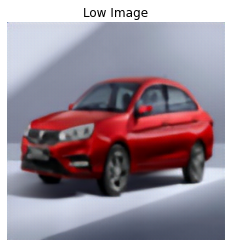

In [19]:
plot_image(Output_02[10], title="Low Image")

In [20]:
print(Origanal_02[10])

tf.Tensor(
[[[215. 217. 233.]
  [215. 218. 233.]
  [215. 218. 232.]
  ...
  [194. 197. 216.]
  [194. 197. 216.]
  [193. 196. 215.]]

 [[215. 217. 233.]
  [215. 218. 233.]
  [215. 218. 232.]
  ...
  [194. 197. 216.]
  [194. 197. 216.]
  [193. 196. 215.]]

 [[215. 217. 232.]
  [215. 218. 232.]
  [215. 218. 232.]
  ...
  [194. 197. 216.]
  [194. 197. 216.]
  [193. 196. 215.]]

 ...

 [[162. 168. 184.]
  [162. 168. 184.]
  [162. 168. 184.]
  ...
  [ 80.  85. 104.]
  [ 80.  85. 104.]
  [ 80.  85. 104.]]

 [[161. 167. 183.]
  [161. 167. 183.]
  [161. 167. 183.]
  ...
  [ 80.  85. 104.]
  [ 80.  85. 104.]
  [ 80.  85. 104.]]

 [[161. 167. 183.]
  [160. 166. 182.]
  [160. 166. 182.]
  ...
  [ 80.  85. 104.]
  [ 80.  85. 104.]
  [ 80.  85. 104.]]], shape=(256, 256, 3), dtype=float32)


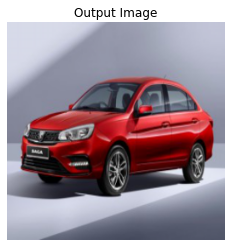

In [21]:
plot_image(Origanal_02[10], title="Output Image")

In [22]:
sum = 0
count = 0
for psnr in PSNR_02:
  sum = sum + psnr
  count = count + 1

print(sum/count)
print(count)

tf.Tensor(26.72724, shape=(), dtype=float32)
70


In [23]:
def plot_imagess(low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,2)
    plt.title('High Image ', color = 'black', fontsize = 20)
    low = np.asarray(low)
    low = tf.clip_by_value(low, 0, 255)
    low = Image.fromarray(tf.cast(low, tf.uint8).numpy())
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    predicted = np.asarray(predicted)
    predicted = tf.clip_by_value(predicted, 0, 255)
    predicted = Image.fromarray(tf.cast(predicted, tf.uint8).numpy())
    plt.imshow(predicted)
    plt.show()

for i in range(0,70):
    plot_imagess(Origanal_02[i],Output_02[i])
    

Output hidden; open in https://colab.research.google.com to view.

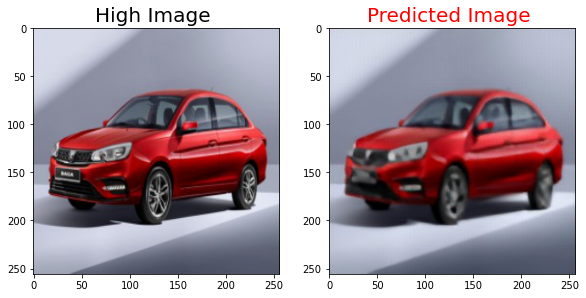

In [24]:
def plot_imagess(low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,2)
    plt.title('High Image ', color = 'black', fontsize = 20)
    low = np.asarray(low)
    low = tf.clip_by_value(low, 0, 255)
    low = Image.fromarray(tf.cast(low, tf.uint8).numpy())
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    predicted = np.asarray(predicted)
    cv2.imwrite("ESGAN_OUTPUT.png", predicted)
    predicted = tf.clip_by_value(predicted, 0, 255)
    predicted = Image.fromarray(tf.cast(predicted, tf.uint8).numpy())
    plt.imshow(predicted)
    plt.show()

plot_imagess(Origanal_02[10],Output_02[10])

In [25]:
A = []
i = 1
for file in PSNR_02:
  A.append(i)
  i = i + 1

In [42]:
print(A)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]


In [39]:
PSNR_03 = []
for numpy in PSNR_02:
  PSNR_03.append(float(numpy))

In [40]:
print(PSNR_03)

[28.624780654907227, 22.17435073852539, 34.00917434692383, 31.53006362915039, 22.32158851623535, 23.06801986694336, 32.92284393310547, 28.563013076782227, 26.02511978149414, 23.64921760559082, 27.377758026123047, 26.314559936523438, 24.82360076904297, 29.61777687072754, 22.05058479309082, 31.347917556762695, 25.71303367614746, 25.160715103149414, 33.37080383300781, 26.482431411743164, 26.12376594543457, 28.788679122924805, 24.494375228881836, 24.17763900756836, 25.30289077758789, 26.924108505249023, 26.192459106445312, 36.155921936035156, 28.937847137451172, 24.321434020996094, 28.105257034301758, 24.677518844604492, 20.339536666870117, 28.862165451049805, 27.004655838012695, 24.388673782348633, 25.94115447998047, 24.824344635009766, 24.739444732666016, 30.43292236328125, 27.816940307617188, 26.64326286315918, 25.151588439941406, 25.689987182617188, 22.790681838989258, 26.531503677368164, 24.485036849975586, 28.47690773010254, 28.677045822143555, 28.70354652404785, 28.663127899169922, 

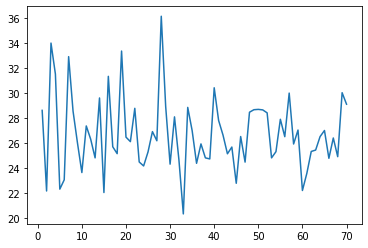

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


sns.lineplot(x = A, y = PSNR_03)
plt.show()

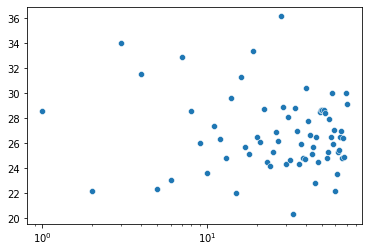

In [43]:
g =sns.scatterplot(x = A, y = PSNR_03)
g.set(xscale="log");

In [37]:
print(float(PSNR_02[0]))
print(PSNR_02[0])

28.624780654907227
tf.Tensor(28.62478, shape=(), dtype=float32)


Trong có phương pháp về xử lý ảnh nhiễu thì hiện nay ESRGAN là một trong những pp tốt nhất và kq PSNR thu được là 26.7(Lí do vì thời gian xử lý khác lâu nên trước khi xử lý phải nén ảnh lại nên kq dẫn đến không tốt như test trên từng ảnh đơn lẻ >40 PSNR), LINK DATASET ĐỂ TEST https://www.kaggle.com/datasets/adityachandrasekhar/image-super-resolution